In [2]:
import os
from PIL import Image
import pandas as pd
import numpy as np

In [9]:
# Method that takes a filepath to the folder containing the cyrillic images. Loops through each file, returning
# a dataframe with the image data and classification in a pandas dataframe.

# TAs: When grading, you can simply pass in the filepath to the folder containing the validation cyrillic images
# into this method and it should return a dataframe with the image data appropriately resized and manipulated.
# HOWEVER NOTE: This method assumes that the structure of passed-in folder is the same as that of
# the folder of cyrillic training data provided. If the folder structure is not the same, then you'll need to write your own for loop
# and then use the get_image_data method found below.

def build_images_data(cyrillic_path):
    df = pd.DataFrame()

    for dirName, subdirList, fileNames in os.walk(cyrillic_path):
        for i, fileName in enumerate(fileNames):
            if fileName.endswith(".png"):
    #             print "{n}. {dirName}/{fileName}".format(n=i, dirName=dirName, fileName=fileName)
                img_bitmap = get_image_data(os.path.join(dirName, fileName))
                character = dirName.split("/")[-1]
                df = df.append(pd.DataFrame([[character, img_bitmap]], columns=['classification', 'imageData']), ignore_index=True)
        
    return df

In [64]:
# Method for taking a filepath to the cyrillic png and returning transformed data.
# This method returns a flat array of 0s and 1s, according to whether the image was black or white.
binarizer = np.vectorize(lambda i: 1 if i > 0 else 0)

IMAGE_EDGE_SIZE = 50

def get_image_data(filepath):
        img = Image.open(filepath)
        img = img.resize((IMAGE_EDGE_SIZE, IMAGE_EDGE_SIZE), Image.ANTIALIAS)
        bitmap = np.array(img.getdata())
        bitmap = bitmap[:,3] # only need the fourth item in the RGB (transparency)
        bitmap = binarizer(bitmap) # change bitmap to 1 or 0
        img.close()
        return bitmap

In [12]:
# Put a Cyrillic folder in the same folder as this file
cyrillic_path = "../Cyrillic"
        
df = build_images_data(cyrillic_path)

df.head()

,classification,imageData
0,Б,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Б,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Б,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Б,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Б,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


In [142]:
y_data = pd.Categorical(df["classification"]).codes
x_data = df["imageData"].values

UNIQUE_CLASSES = pd.Categorical(df['classification']).unique()
N_CLASSES = len(UNIQUE_CLASSES)

# Train Neural Net

In [156]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.3)

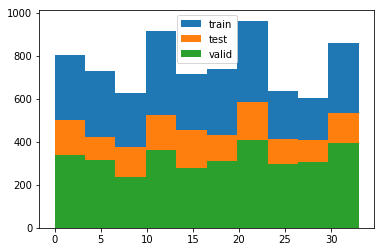

In [157]:
import matplotlib.pyplot as plt

plt.hist(y_train)
plt.hist(y_test)
plt.hist(y_valid)
plt.legend(["train", "test", "valid"])
plt.show()

In [159]:
# Format the y data into an array of 34 items, with 1 for the correct answer

import keras.utils as kutils

y_train = kutils.to_categorical(y_train, num_classes=N_CLASSES, dtype='int8')
y_test  = kutils.to_categorical(y_test,  num_classes=N_CLASSES, dtype='int8')
y_valid = kutils.to_categorical(y_valid, num_classes=N_CLASSES, dtype='int8')

In [161]:
from keras.models import Sequential
from keras.layers import Dense

nn = Sequential()

Layer1 = Dense(units=100, activation='relu', input_dim=IMAGE_EDGE_SIZE**2)
Layer2 = Dense(units=80, activation='relu')
Layer3 = Dense(units=50, activation='relu')
Layer4 = Dense(units=20, activation='relu')

OutputLayer = Dense(units=N_CLASSES, activation='softmax')

nn.add(Layer1)
nn.add(Layer2)
nn.add(Layer3)
nn.add(Layer4)

nn.add(OutputLayer)

In [162]:
nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [163]:
nn.fit(x_train, y_train, epochs=20, batch_size=50)

ValueError: Error when checking input: expected dense_36_input to have shape (2500,) but got array with shape (1,)